In [1]:
import numpy as np
import wandb

import shutil

import torch
import scipy
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import tabulate

import itertools

from matplotlib import rc

rc('text', usetex=True)
rc('font',**{'family':'serif','serif':['Computer Modern Roman']})

%matplotlib inline
palette = sns.color_palette()

api = wandb.Api()

In [2]:
# Code template to download saved feature respresentations from wandb
"""
run_records = [    
    (<support_h500_run_id>, 'support_h500'),
    (<dann_run_id>, 'dann'),
    (<no_da_run_id>, 'no_da'),
]

step = 30000

for run_id, name in run_records:
    run = api.run(f'timgaripov/support_alignment_v2/{run_id}')
    fname = f'features_step_{step:06d}.pkl'
    run.file(fname).download('./data_2d_features', replace=True)
    shutil.move(f'./data_2d_features/{fname}', f'./data_2d_features/features_{name}.pkl')
"""
pass

In [3]:
! ls ./data_2d_features

features_dann.pkl         features_no_da.pkl
features_name.pkl         features_support_h500.pkl


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


(1779, 2) (8252, 2)


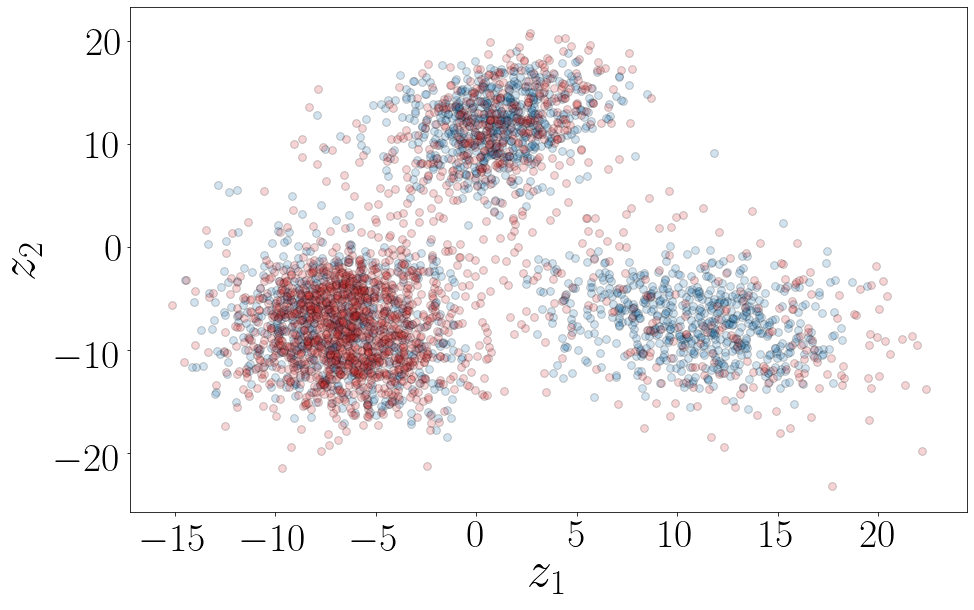

In [4]:
feature_info = torch.load(f'./data_2d_features/features_support_h500.pkl')

N = 2000
np.random.seed(1)

x_src = feature_info['features_src_tr'].numpy()
y_src = feature_info['labels_src_tr'].numpy()

x_trg = feature_info['features_trg_tr'].numpy()
y_trg = feature_info['labels_trg_tr'].numpy()

print(x_src.shape, x_trg.shape)

index_src = np.random.choice(x_src.shape[0], size=min(x_src.shape[0], N), replace=False)
x_s_src = x_src[index_src, :]
y_s_src = y_src[index_src]



index_trg = np.random.choice(x_trg.shape[0], size=min(x_trg.shape[0], N), replace=False)
x_s_trg = x_trg[index_trg, :]
y_s_trg = y_trg[index_trg]

fix = plt.figure(figsize=(15, 9.3))

plt.scatter(x_s_src[:, 0], x_s_src[:, 1], c=palette[0], marker='o', s=60, alpha=0.2, edgecolors='k')
plt.scatter(x_s_trg[:, 0], x_s_trg[:, 1], c=palette[3], marker='o', s=60, alpha=0.2, edgecolors='k')

            
plt.xlabel('$z_1$', fontsize=50)
plt.ylabel('$z_2$', fontsize=50)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)

plt.show()

In [5]:
names = ['no_da', 'dann', 'support_h500']
feature_info_dict = {name: torch.load(f'./data_2d_features/features_{name}.pkl') for name in names}

no_da


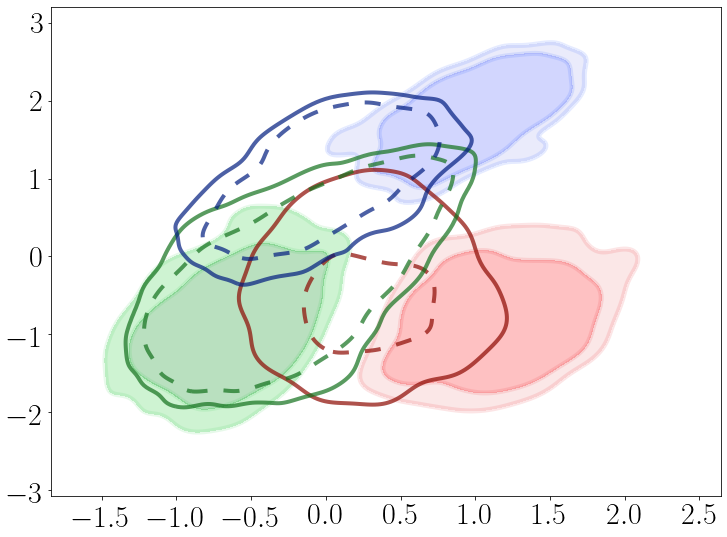

dann


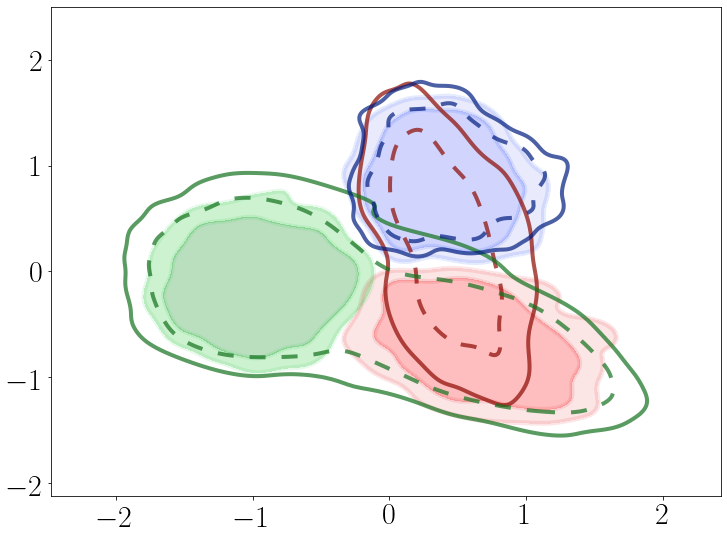

support_h500


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


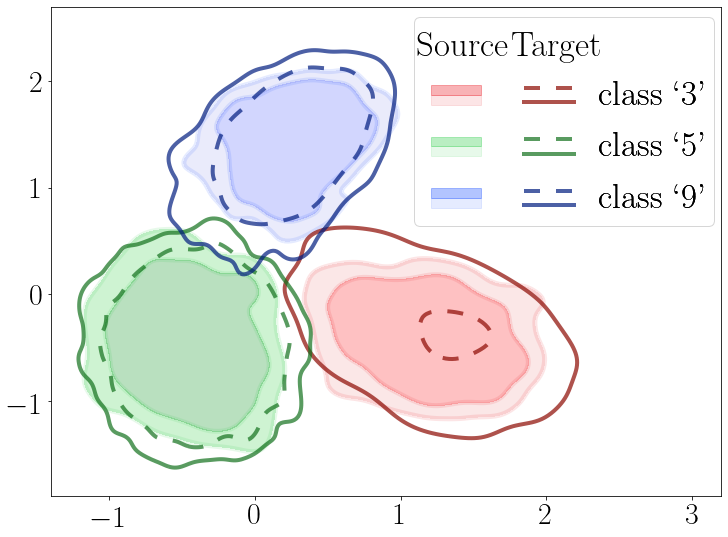

In [6]:
from matplotlib.patches import Rectangle, Patch
from matplotlib.lines import Line2D
from matplotlib.collections import LineCollection
from matplotlib.legend_handler import HandlerBase


class TwoLinesHandle(object):
    def __init__(self, color):
        self.color = color

class TwoLinesHandler(HandlerBase):
    def create_artists(self, legend, orig_handle,
                       x0, y0, width, height, fontsize, trans):
        l1 = plt.Line2D([x0 + 0.2 * width, x0+width], [0.8*height,0.8*height], color=orig_handle.color, alpha=0.7, lw=4, ls=(0, (4, 4)))
        l2 = plt.Line2D([x0 + 0.2 * width, x0+width], [0.2*height,0.2*height], color=orig_handle.color, alpha=0.7, lw=4)
        return [l1, l2]
    
    
class TwoPatchesHandle(object):
    def __init__(self, color):
        self.color = color

class TwoPatchesHandler(object):
    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        x0, y0 = handlebox.xdescent, handlebox.ydescent
        width, height = handlebox.width, handlebox.height
        patch1 = Rectangle([x0 + 0.2 * width, y0 + 0.1 * height], 0.8 * width, 0.4*height, color=orig_handle.color, alpha=0.1,                                    
                           transform=handlebox.get_transform())
        patch2 = Rectangle([x0 + 0.2 * width, y0 + 0.5 * height], 0.8 * width, 0.4*height, color=orig_handle.color, alpha=0.3,                                    
                           transform=handlebox.get_transform())        
        handlebox.add_artist(patch1)
        handlebox.add_artist(patch2)
        return [patch1, patch2]

bw_adjust = 1.0

for i, name in enumerate(names):
    print(name)
    
    feature_info = feature_info_dict[name]
    


    paired_palette = sns.color_palette("Paired")
    palette_src = [sns.color_palette('bright')[i] for i in [3, 2, 0]]
    palette_trg = [sns.color_palette('dark')[i] for i in [3, 2, 0]]


    N = 400
    np.random.seed(1)

    x_src = feature_info['features_src_tr'].numpy().copy()
    y_src = feature_info['labels_src_tr'].numpy().copy()

    x_trg = feature_info['features_trg_tr'].numpy().copy()
    y_trg = feature_info['labels_trg_tr'].numpy().copy()
    
    x_combined = np.concatenate([x_src, x_trg], axis=0)
    shift = np.mean(x_combined, axis=0)
    x_combined -= shift[None, :]    
    x_src -= shift[None, :]
    x_trg -= shift[None, :]
        
    
    scale = np.mean(np.linalg.norm(x_combined, axis=1), axis=0)
    x_combined /= scale
    x_src /= scale
    x_trg /= scale
    
    index_src = np.random.choice(x_src.shape[0], size=N, replace=False)
    x_s_src = x_src[index_src, :]
    y_s_src = y_src[index_src]

    index_trg = np.random.choice(x_trg.shape[0], size=N, replace=False)
    x_s_trg = x_trg[index_trg, :]
    y_s_trg = y_trg[index_trg]

    
    fig = plt.figure(figsize=(12, 9))

        
    for c in range(3):    
        x_c_src = x_src[y_src == c]        

        x_c_trg = x_trg[y_trg == c]        

    sns.kdeplot(x=x_src[:, 0], y=x_src[:, 1], hue=y_src, palette=palette_src, common_norm=True, legend=False,
                bw_adjust=bw_adjust, levels=[0.04, 0.15, 1.0], fill=True, alpha=0.3)
    sns.kdeplot(x=x_src[:, 0], y=x_src[:, 1], hue=y_src, palette=palette_src, common_norm=True, legend=False,
                bw_adjust=bw_adjust, levels=[0.04, 0.15, 1.0], alpha=0.1, linewidths=5)

    sns.kdeplot(x=x_trg[:, 0], y=x_trg[:, 1], hue=y_trg, palette=palette_trg, common_norm=True, legend=False,
                bw_adjust=bw_adjust, levels=[0.04, 0.15], alpha=0.7, linewidths=4, linestyles=['solid', (0, (4, 4))])

    
    cnames = ["class `3'", "class `5'", "class `9'"]
    
    if i == 2:
        ax = plt.gca()
        
        src_legend_handles = []
        trg_legend_handles = []        
        for c in range(3):            
            trg_legend_handles.append(TwoLinesHandle(color=palette_trg[c]))
            src_legend_handles.append(TwoPatchesHandle(color=palette_src[c]))
            
        r = matplotlib.patches.Rectangle((0,0), 1, 1, fill=False, edgecolor='none', visible=False)
            
        frame_legend = plt.legend(labels=[""], handles=[r],                                 
                                  fontsize=30, handlelength=3.2,
                                  borderpad=3.0, 
                                  loc='upper left', bbox_to_anchor=(0.52, 1.01), #, 0.3, 0.4),
                                  frameon=True)
        plt.gca().add_artist(frame_legend)
        
        trg_legend = plt.legend(labels=[""] * 3, handles=trg_legend_handles, 
                                handler_map={TwoLinesHandle: TwoLinesHandler()},
                                title='Target', fontsize=35, title_fontsize=35, handlelength=1.8,
                                loc='upper left', bbox_to_anchor=(0.64, 1.02),
                                frameon=False)
        plt.gca().add_artist(trg_legend)
        
        src_legend = plt.legend(labels=[""] * 3, handles=src_legend_handles, 
                                handler_map={TwoPatchesHandle: TwoPatchesHandler()},
                                title='Source', fontsize=35, title_fontsize=35, handlelength=1.8,
                                loc='upper left', bbox_to_anchor=(0.50, 1.02),
                                frameon=False)
        plt.gca().add_artist(src_legend)
        
        
        class_legend = plt.legend(labels=cnames, handles=[r] * 3,                                 
                                  fontsize=35, handlelength=0.0,
                                  loc='upper left', bbox_to_anchor=(0.73, 0.92),
                                  frameon=False)
        plt.gca().add_artist(class_legend)
        
        plt.xlim([-1.4, 3.2])
        plt.ylim([-1.9, 2.7])
    
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)

    plt.savefig(f'./figures/vis2d_{name}.pdf', format='pdf', bbox_inches='tight')
    plt.show()
    
    